# Notebook to demonstrate the climate.aggregate tools available

In [1]:
# If first time running, uncomment the line below to install any additional dependancies
# !bash requirements-for-notebooks.sh

In [6]:
from earthkit.climate import aggregate as ek_aggregate
from earthkit import data as ek_data

from earthkit.data.testing import earthkit_remote_test_data_file

# Load some test data

All `earthkit-climate` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray`.

In this example we will use hourly ERA5 2m temperature data on a 0.5x0.5 spatial grid for the year 2015 as
our physical data; and we will use the NUTS geometries which are stored in a geojson file.

First we lazily load the ERA5 data  and NUTS geometries from our test-data repository.

Note the data is only downloaded when
we use it, e.g. at the `.to_xarray` line, additionally, the download is cached so the next time you run this
cell you will not need to re-download the file (unless it has been a very long time since you have run the
code, please see tutorials in `earthkit-data` for more details in cache management).

In [7]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_2015.grib")
era5_data = ek_data.from_source("url", remote_era5_file)
era5_data.to_xarray()

<xarray.Dataset>
Dimensions:     (number: 1, time: 1460, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-04T13:40 GRIB to CDM+CF via cfgrib-0.9.1...

## Calculate the daily mean of the ERA5 data

In [9]:
era5_daily_mean = ek_aggregate.temporal.daily_mean(era5_data)
era5_daily_mean

<xarray.Dataset>
Dimensions:    (number: 1, step: 1, surface: 1, latitude: 201, longitude: 281,
                time: 365)
Coordinates:
  * number     (number) int64 0
  * step       (step) timedelta64[ns] 00:00:00
  * surface    (surface) float64 0.0
  * latitude   (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
Data variables:
    t2m        (time, number, step, surface, latitude, longitude) float32 254...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-04T13:40 GRIB to CDM+CF via cfgrib-0.9.1...

## Calculate a rolling mean with a 50 timestep window

In [11]:
era5_rolling = ek_aggregate.temporal.rolling_reduce(
    era5_data, time=50, center=True, how_dropna='all'
)
era5_rolling

<xarray.Dataset>
Dimensions:     (number: 1, time: 1411, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-07T06:00:00 ... 2015-12-25T18:0...
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 2015-01-07T06:00:00 ... 2015-12-2...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 26...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-04T13:41 GRIB to CDM+CF via cfgrib-0.9.1...

## Plot a random point location to see the different aggregation methods

Text(0.5, 1.0, 'Aggregation methods')

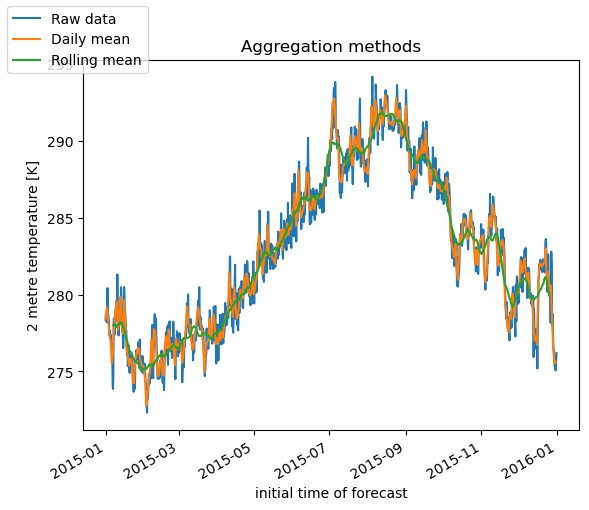

In [12]:
isel_kwargs = {"latitude":100, "longitude":100}
era5_data.to_xarray().t2m.isel(**isel_kwargs).plot(label='Raw data')
era5_daily_mean.t2m.isel(**isel_kwargs).plot(label='Daily mean')
fig = era5_rolling.t2m.isel(**isel_kwargs).plot(label='Rolling mean')
figure = fig[0].get_figure()
figure.legend(loc=2)
figure.axes[0].set_title("Aggregation methods")

In [15]:
era5_rolling_multidim = ek_aggregate.temporal.rolling_reduce(
    era5_data, time=30, lat=5, lon=5, center=True,
    how_dropna='all'
)
era5_rolling_multidim

<xarray.Dataset>
Dimensions:     (number: 1, time: 1431, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-04T18:00:00 ... 2015-12-28T06:0...
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 2015-01-04T18:00:00 ... 2015-12-2...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 26...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-04T13:41 GRIB to CDM+CF via cfgrib-0.9.1...

In [16]:
ek_aggregate.temporal.reduce(era5_data, how='quantile', q=[0.1, 0.9], dim='time')

<xarray.DataArray 't2m' (quantile: 2, number: 1, step: 1, surface: 1,
                         latitude: 201, longitude: 281)>
array([[[[[[251.29398956, 251.2955246 , 251.3064621 , ...,
            253.05757446, 252.94672852, 253.0042038 ],
           [251.65618744, 251.64010925, 251.64205933, ...,
            253.29236298, 253.13531494, 253.08552094],
           [251.85378723, 251.79356995, 251.76828613, ...,
            253.1875061 , 253.19468842, 253.13249969],
           ...,
           [288.33457031, 287.59075317, 286.102948  , ...,
            283.25070801, 282.1447113 , 280.52984009],
           [288.22132263, 287.81262817, 286.11167603, ...,
            283.50424805, 281.93889771, 280.04655762],
           [288.35160217, 287.80015869, 285.84237061, ...,
            284.19384155, 282.6529541 , 280.37278137]]]]],




       [[[[[273.65534668, 273.72172852, 273.75725098, ...,
            274.27275391, 274.34187012, 274.40029297],
           [273.64194336, 273.69060059, 273.74213867, ...,
            274.47819824, 274.49052734, 274.50446777],
           [273.66333008, 273.70446777, 273.73937988, ...,
            274.72021484, 274.72485352, 274.72607422],
           ...,
           [294.84934082, 297.93703613, 302.24023438, ...,
            311.53522949, 309.47807617, 307.23876953],
           [294.10366211, 294.86873169, 298.98916016, ...,
            311.50227051, 309.44924316, 306.79521484],
           [294.25411987, 296.29506836, 298.81289063, ...,
            312.32009277, 310.10639648, 306.86450195]]]]]])
Coordinates:
  * number     (number) int64 0
  * step       (step) timedelta64[ns] 00:00:00
  * surface    (surface) float64 0.0
  * latitude   (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
  * quantile   (quantile) float64 0.1 0.9

In [17]:
rolling_kwargs =  {'time': 50, 'center': True}
reduce_kwargs =  {}
data_rolling = era5_data.to_xarray().rolling(**rolling_kwargs)
data_rolling

DatasetRolling [time->50(center)]

In [18]:
ek_aggregate.temporal.reduce(data_rolling)

Cannot find a wrapper for class: xarray.core.rolling.DatasetRolling, returning unwrapped object
Cannot find a wrapper for class: xarray.core.rolling.DatasetRolling, returning unwrapped object


<xarray.Dataset>
Dimensions:     (number: 1, time: 1460, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 na...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-04T13:42 GRIB to CDM+CF via cfgrib-0.9.1...